# Experimenting with deconvolution

Here we show how to use each of the deconvolution functions in DIPlib

This notebook shows:
 - How to create a corrupted test image
 - How to create a plausible unsharp point spread function as convolution kernel
 - Which deconvolution functions are available in DIPlib, how to call them, and how they compare

In [1]:
import diplib as dip

DIPlib -- a quantitative image analysis library
Version 3.3.0 (Jul  2 2022)
For more information see https://diplib.org


The DIPlib version number shown above is not the release used to create this file. We used the development version of DIPlib, compiled after the 3.3.0 release, as we added the various deconvolution algorithms to it.

## Create a test image

We first create a test image.

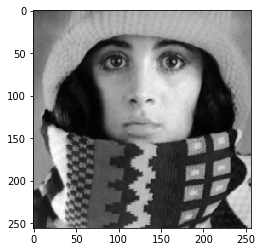

In [2]:
img = dip.ImageRead('../trui.ics')
img = dip.ContrastStretch(img)
img.Show('8bit')

Next we create a defocussed PSF (the PSF from a confocal microscope in a plane outside the focal plane).

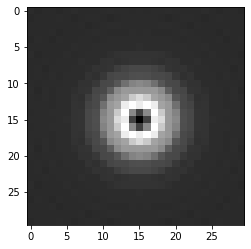

In [3]:
K = dip.IncoherentOTF([30,30], 0.9)
k = dip.FourierTransform(K, {'inverse','real'})
k.Show()

Finally we corrupt the image by convolving with the PSF and adding noise.

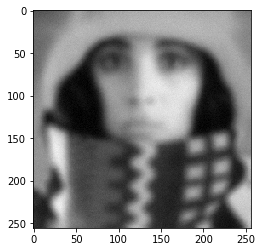

In [4]:
g = dip.Convolution(img, k, method='fourier')
dip.ReseedRng(0)  # force every run of this notebook to produce the same noise instance
g = dip.GaussianNoise(g, 10)
g = dip.ClipLow(g)
g.Show('8bit')

## Wiener deconvolution

This is the most well known deconvolution filter. It is a linear filter, obtained by minimizing a specific cost function.

Like for all other filters, we need to tweak the `regularization` parameter until we get useful results. Make it larger to get a smoother output, smaller to get a sharper but noisier output. What the best value is depends on so many things...

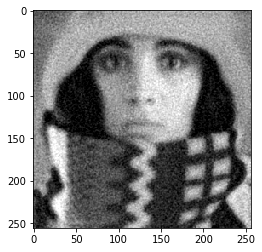

In [5]:
f_wd = dip.WienerDeconvolution(g, k, regularization=0.005)
f_wd.Show('8bit')

If we don't use the "pad" option (which is the default), the edge effects take over. But note that for some images it might not be necessary to pad. This "pad" option is applied by default to all deconvolution algorithms in DIPlib.

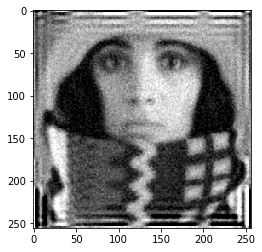

In [6]:
dip.WienerDeconvolution(g, k, regularization=0.005, options=set()).Show('8bit')

## Tikhonov-Miller deconvolution

This is a different linear filter, constructed by minimizing a different cost function. The regularization parameter here has a different meaning, do not compare its value to that used in the Wiener filter.

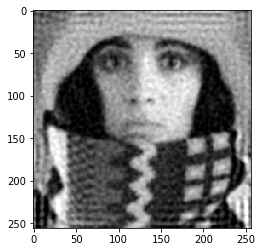

In [7]:
f_tm = dip.TikhonovMiller(g, k, regularization=0.1)
f_tm.Show('8bit')

# Iterative Constrained Tikhonov-Miller (ICTM) deconvolution

This method uses gradient descent to minimize the same cost function as Tikhonov-Miller. Depending on the characteristics of the PSF, how well the PSF is estimated, and the amount of noise, this can lead either to the same answer or a more useful result. The iterative gradient descent process allows to apply constraint to the result, in this case it is a non-negativity constraint. Every iteration, negative values are clipped to zero. 

In this case, we can reduce the regularization parameter and find a sharper image without amplifying the noise as much as the linear filter does.

The function implements two variants: one using steepest descent with a fixed step size (given by the `stepSize` parameter), and one using conjugate gradients using an optimal step size. The latter tends to converge much more quickly (here we use 300 iterations for the steepest descent method, and 11 for the conjugate gradients method to produce a similar result).

The number of iterations is a form of regularization as well. Cutting off the optimization before convergence leads to a less noisy result. Normally one would set a non-zero `convergence` value, say 1e-6 (the default), and set `maxIterations` to some large value, to allow the algorithm to run until convergence. If the mean square error between `dip.Convolution(f, k)` and `g` changes less than `tolerance * max(g)**2` from one step to the next, then the algorithm stops (where `f` is the solution after the current step).

Here we set `tolerance=0` to iterate exactly `maxIterations` times.

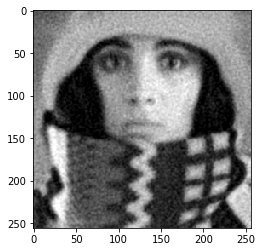

In [8]:
f_ictm_sd = dip.IterativeConstrainedTikhonovMiller(
    g, k,
    regularization=0.01,
    tolerance=0,
    maxIterations=300,
    stepSize=0.5)
f_ictm_sd.Show('8bit')

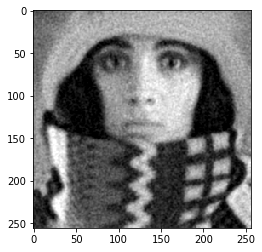

In [9]:
f_ictm_cg = dip.IterativeConstrainedTikhonovMiller(
    g, k,
    regularization=0.01,
    tolerance=0,
    maxIterations=11)
f_ictm_cg.Show('8bit')

Let's look at this last function's progression as we increase the number of iterations, and compare that to the linear Tikhonov-Miller filter with the same regularization parameter value. (The `tolerance` parameter is set to zero to force all iterations to be computed.)

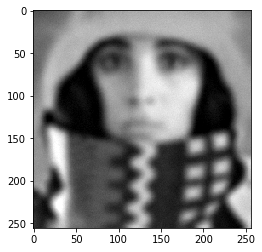

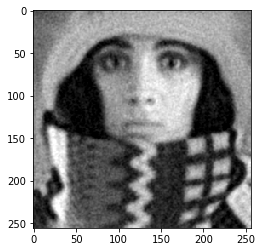

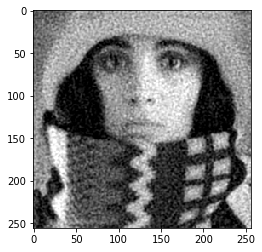

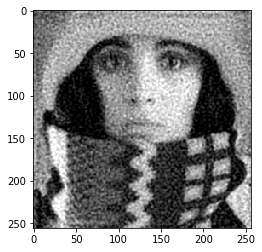

Non-iterative Tikhonov-Miller:


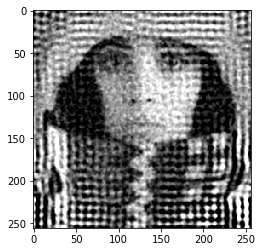

In [10]:
dip.IterativeConstrainedTikhonovMiller(g, k, regularization=0.01, tolerance=0, maxIterations= 1).Show('8bit')
dip.IterativeConstrainedTikhonovMiller(g, k, regularization=0.01, tolerance=0, maxIterations=10).Show('8bit')
dip.IterativeConstrainedTikhonovMiller(g, k, regularization=0.01, tolerance=0, maxIterations=20).Show('8bit')
dip.IterativeConstrainedTikhonovMiller(g, k, regularization=0.01, tolerance=0, maxIterations=30).Show('8bit')
print("Non-iterative Tikhonov-Miller:")
dip.TikhonovMiller(g, k, regularization=0.01, options={"pad"}).Show('8bit')

## Richardson-Lucy (RL) deconvolution

This methods uses the expectation maximization (EM) algorithm to maximize the likelyhood of the target image given the input image and the input PSF, assuming a Poisson noise model. This algorithm has no regularization, and therefore the number of iterations (`nIterations`) is important: one must stop the algorithm before the noise is amplified too much. The number of steps thus functions as the regularization.

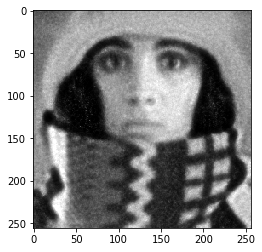

In [11]:
f_rl = dip.RichardsonLucy(
    g, k,
    regularization=0,
    nIterations=100)
f_rl.Show('8bit')

Here we run the algorithm with three different values for `nIterations`:

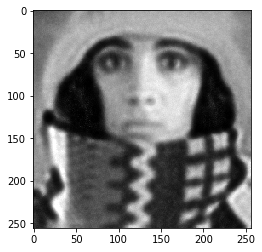

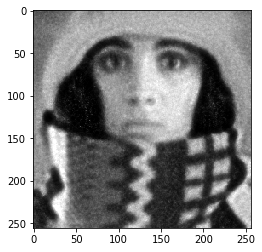

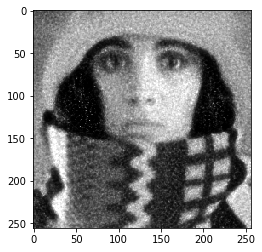

In [12]:
dip.RichardsonLucy(g, k, regularization=0, nIterations=50).Show('8bit')
dip.RichardsonLucy(g, k, regularization=0, nIterations=100).Show('8bit')
dip.RichardsonLucy(g, k, regularization=0, nIterations=200).Show('8bit')

You might have noticed the `regularization` parameter in the function call above. Setting this to a non-zero value adds total variation (TV) regularization to the algorithm. TV tends to impose a "staircase" character to the regularized result, with flat regions and sharp transitions in between.

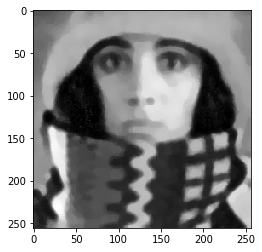

In [13]:
f_rl_tv = dip.RichardsonLucy(
    g, k,
    regularization=0.005,
    nIterations=100)
f_rl_tv.Show('8bit')

## Fast Iterative Shrinkage-Thresholding (FISTA) deconvolution

This method uses the FISTA optimization algorithm, which applies $l_1$ regularization. This is a nice algorithm with lots of caveats.

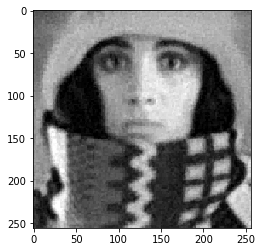

In [14]:
f_fista = dip.FastIterativeShrinkageThresholding(
    g, k,
    regularization=0.2,
    maxIterations=30)
f_fista.Show('8bit')

The Shrinkage-Thresholding regularization is implemented through a Haar wavelet transform, which tends to produce blocky images. Below we iterate up to 300 times (to ensure convergence) and increase the regularization parameter. Note that it is impossible to regularize sufficiently without introducing this blockiness.

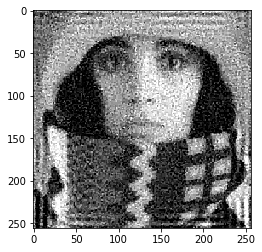

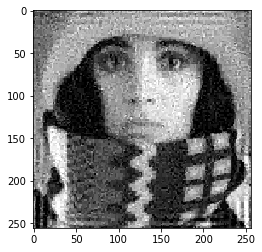

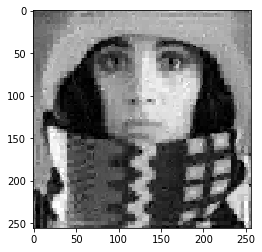

In [15]:
dip.FastIterativeShrinkageThresholding(g, k, regularization=0.1, maxIterations=300).Show('8bit')
dip.FastIterativeShrinkageThresholding(g, k, regularization=0.2, maxIterations=300).Show('8bit')
dip.FastIterativeShrinkageThresholding(g, k, regularization=0.5, maxIterations=300).Show('8bit')

But terminating the iterations early also prevents the noise from becoming too strong (note `tolerance=0` to iterate exactly `maxIterations` times):

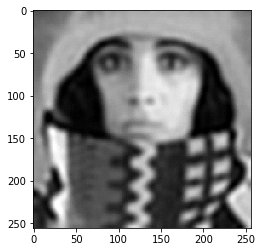

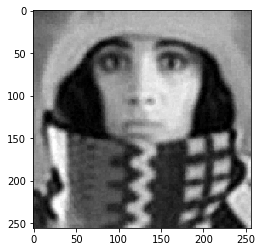

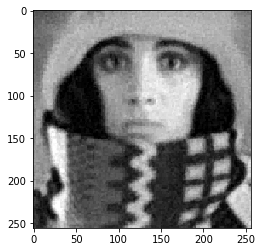

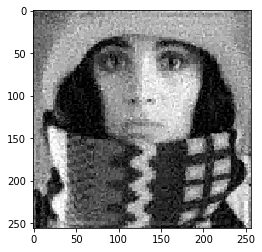

In [16]:
dip.FastIterativeShrinkageThresholding(g, k, regularization=0.2, maxIterations=10, tolerance=0).Show('8bit')
dip.FastIterativeShrinkageThresholding(g, k, regularization=0.2, maxIterations=20, tolerance=0).Show('8bit')
dip.FastIterativeShrinkageThresholding(g, k, regularization=0.2, maxIterations=30, tolerance=0).Show('8bit')
dip.FastIterativeShrinkageThresholding(g, k, regularization=0.2, maxIterations=60, tolerance=0).Show('8bit')